# This workbook will describe the process of predict depth at a Combined Sewer Overflow based on catchment rainfall data. An additional feature (time of day) will be used to test if the model is sensitive enough to predict a diurnal profile based on this real usecase in a small catchment 


In [29]:
#import libaries and set up dependencies
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from __future__ import print_function
import tensorflow as tf

# Uncomment the below lines to check that the correct setup has been made for CUDA acceleration of the neural network

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
#mport plotly.graph_objects as go 

from tensorflow import keras

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.python.keras import backend as k


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)


# fix random seed for reproducibility
np.random.seed(10)



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8324930438596062408
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22726836224
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7869862344468075201
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1


## The first step is to import and format teh recorded historical data so that it can be used for modelling

In [6]:
#Load rainfall dataframe
df_rain = pd.read_csv("D://Linuxstuff/Minworth Rain/df_rain.csv")
df_rain['date_time'] = pd.to_datetime(df_rain['date_time'],dayfirst=True)
#df_rain.to_hdf("/media/nosamaj/Big Disk/Linuxstuff/Minworth Rain/df_rain.hd5",key='df_rain', mode='w')
df_rain.dtypes
df_rain.head(-5)

Unnamed: 0             int64
time                 float64
date_time     datetime64[ns]
RG7                  float64
RG12                 float64
RG15                 float64
RG16                 float64
RG24                 float64
RG28                 float64
RG33                 float64
RG34                 float64
RG35                 float64
RG40                 float64
RG50                 float64
RG52                 float64
RG64                 float64
dtype: object

,Unnamed: 0,time,date_time,RG7,RG12,RG15,RG16,RG24,RG28,RG33,RG34,RG35,RG40,RG50,RG52,RG64
0,1,NaN,2011-12-09 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,NaN,2011-12-09 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,NaN,2011-12-09 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,NaN,2011-12-09 00:06:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,NaN,2011-12-09 00:08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494594,3557920,NaN,2021-05-05 23:42:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2494595,3557921,NaN,2021-05-05 23:44:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2494596,3557922,NaN,2021-05-05 23:46:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2494597,3557923,NaN,2021-05-05 23:48:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Based on GIS assessment and catchment knowledgfe me need profiles 9 10 and 13 from the inforworks model. These correspond to RG35, RG40 and RG64 

In [7]:
df_rain_local = df_rain[['date_time','RG35','RG40','RG64']]
df_rain_local.head()
df_rain_local.dtypes

,date_time,RG35,RG40,RG64
0,2011-12-09 00:00:00,0.0,0.0,0.0
1,2011-12-09 00:02:00,0.0,0.0,0.0
2,2011-12-09 00:04:00,0.0,0.0,0.0
3,2011-12-09 00:06:00,0.0,0.0,0.0
4,2011-12-09 00:08:00,0.0,0.0,0.0


date_time    datetime64[ns]
RG35                float64
RG40                float64
RG64                float64
dtype: object

### Importing and formatting the CSO level data

In [8]:
data_from = pd.to_datetime('2017-01-01 00:00')
data_to = pd.to_datetime('2021-01-01 00:00')

df_logger = pd.read_csv('./dataset/STWW11075.csv')
df_logger['DateTime'] = pd.to_datetime(df_logger['DateTime'],dayfirst=True, infer_datetime_format=True)

### There are some clear recording issues in this data that need to be cleaned up. As an initial pass we are going to just set any readings <0 to 0 as this is the lowest phsically possible value. This will still represent a real world quality dataset without throwing off the training process with outliers

In [9]:
df_logger["C1 Depth (mm)"] = df_logger["C1 Depth (mm)"].clip(lower=0)
#fig = px.line(df_logger, x="DateTime", y= "C1 Depth (mm)", width = 1600)
#fig.show()

### Merging the level data with rainfall data based on the timestamp to create a single table for the recorded period. The level data begins incorrectly formatted. The period for the train test procedure will be 01/01/2017 to 01/01/2021



In [10]:
df_dataset = pd.merge(df_logger, df_rain_local, left_on = "DateTime", right_on = "date_time")
df_dataset = df_dataset.drop("date_time", axis = 1)
df_dataset.head(-5)

,DateTime,C1 Depth (mm),RG35,RG40,RG64
0,2016-10-04 00:52:00,0.0,0.0,0.0,0.0
1,2016-10-04 00:54:00,0.0,0.0,0.0,0.0
2,2016-10-04 01:10:00,46.0,0.0,0.0,0.0
3,2016-10-04 01:12:00,46.0,0.0,0.0,0.0
4,2016-10-04 01:32:00,46.0,0.0,0.0,0.0
...,...,...,...,...,...
1218532,2021-05-05 23:42:00,42.0,0.0,0.0,0.0
1218533,2021-05-05 23:44:00,41.0,0.0,0.0,0.0
1218534,2021-05-05 23:46:00,40.0,0.0,0.0,0.0
1218535,2021-05-05 23:48:00,39.0,0.0,0.0,0.0


In [11]:
data_from = pd.to_datetime('2017-01-01 00:00')
data_to = pd.to_datetime('2021-01-01 00:00')



df_input = df_dataset[df_dataset['DateTime'] >=data_from]
df_testtrain = df_input[df_input['DateTime'] < data_to]
df_testtrain.head()
df_unseen = df_dataset[df_dataset['DateTime'] >= data_to]



,DateTime,C1 Depth (mm),RG35,RG40,RG64
70567,2017-01-01 00:00:00,42.0,0.0,0.0,0.0
70568,2017-01-01 00:02:00,42.0,0.0,0.0,0.0
70569,2017-01-01 00:04:00,42.0,0.0,0.0,0.0
70570,2017-01-01 00:06:00,42.0,0.0,0.0,0.0
70571,2017-01-01 00:08:00,42.0,0.0,0.0,0.0


## Data Transformation

### The data for the date and time parameters needs to be transformed into numerical features for the LSTM to function. Creating columns for the month, weekday, hour and minute separately should suffice

In [12]:
#set the field containing timestamp values as index
df_transform = df_dataset.set_index('DateTime')
#fetch the timestamp componnents and create columns
df_transform['year'] = df_transform.index.year
df_transform['month'] = df_transform.index.month
df_transform['day'] = df_transform.index.weekday
df_transform['week'] = df_transform.index.week
df_transform['hour'] = df_transform.index.hour
df_transform['minute'] = df_transform.index.minute
#see if it worked 
df_transform.head()

C:\Users\jam_m\AppData\Local\Temp/ipykernel_14696/60620551.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_transform['week'] = df_transform.index.week


,C1 Depth (mm),RG35,RG40,RG64,year,month,day,week,hour,minute
DateTime,,,,,,,,,,
2016-10-04 00:52:00,0.0,0.0,0.0,0.0,2016,10,1,40,0,52
2016-10-04 00:54:00,0.0,0.0,0.0,0.0,2016,10,1,40,0,54
2016-10-04 01:10:00,46.0,0.0,0.0,0.0,2016,10,1,40,1,10
2016-10-04 01:12:00,46.0,0.0,0.0,0.0,2016,10,1,40,1,12
2016-10-04 01:32:00,46.0,0.0,0.0,0.0,2016,10,1,40,1,32


In [13]:
# plot dataset for visualiseation
dataset   = df_transform.values
dataset   = df_transform.astype('float32')
#plt.plot(dataset)

In [14]:
# normalize the dataset
scaler  = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

The data set comtains a depth in mm and therefore of the order 100, rainfall intesnisty in mm/hr of the order 1 and a decimal time vaule. Therefore it is crucial that the data is standardsised as the significance of the inputs is crucial.

In [15]:
# split into train and test sets this is a 90% train 10% test 
train_size  = int(len(dataset) * 0.75)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#count datapoints to check the split
print(len(train), len(test))

913906 304636


In [16]:
#plot the datasets for visualisation
#print('----------------- TRAINING DATA -----------------')
#plt.plot(train)
#plt.show()
#print('----------------- TEST DATA -----------------')
#plt.plot(test)
#plt.show()


As this is a timeseries sequience problem we need to create a sliding window to determine what period of data we are going to take into account to make predictions. 

In [17]:
# This function creates a sliding window of the dataset.
def create_dataset(dataset, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sliding_window-1):
        a = dataset[i:(i+sliding_window), [1,2,3,5,6,7,8,9]]
        dataX.append(a)
        dataY.append(dataset[i + sliding_window, 0])
    return np.array(dataX), np.array(dataY)


In [18]:
# use a n-10 sliding window equivalent to 2 hours of historical data - i.e. we are applying the winddow in this cell
slide_window   = 120
trainX, trainY = create_dataset(train, slide_window)
testX, testY   = create_dataset(test, slide_window)    

## We can now reshape teh datasets to be used as tensors for the keras dequential LSTM model and train it based on the training dataset

In [19]:
trainX = np.reshape(trainX, (trainX.shape[0], 8, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 8, testX.shape[1]))

In [20]:
#Setup the LSTM
model = tf.keras.Sequential()
model.add(LSTM(64, input_dim=slide_window, return_sequences = True))
model.add(LSTM(128, input_dim=slide_window, return_sequences = True))
model.add(LSTM(64, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=120, verbose=1)
#add validation dataset to see validation losses

Epoch 1/10
7615/7615 [==============================] - 64s 7ms/step - loss: 3.1661e-04
Epoch 2/10
7615/7615 [==============================] - 55s 7ms/step - loss: 2.5571e-04
Epoch 3/10
7615/7615 [==============================] - 55s 7ms/step - loss: 2.2318e-04
Epoch 4/10
7615/7615 [==============================] - 57s 7ms/step - loss: 2.0685e-04
Epoch 5/10
7615/7615 [==============================] - 55s 7ms/step - loss: 1.9404e-04
Epoch 6/10
7615/7615 [==============================] - 55s 7ms/step - loss: 1.8553e-04
Epoch 7/10
7615/7615 [==============================] - 55s 7ms/step - loss: 1.8248e-04
Epoch 8/10
7615/7615 [==============================] - 55s 7ms/step - loss: 1.7556e-04
Epoch 9/10
7615/7615 [==============================] - 54s 7ms/step - loss: 1.7529e-04
Epoch 10/10
7615/7615 [==============================] - 55s 7ms/step - loss: 1.6239e-04


I haven't had time to play around with hyperparameters. Batch size has been set to 100 in order to make full use of the GPU accelleration

## We can finally see what the predictiosn are doing for us, firstly in the training dataset, and then in the test dataset

In [21]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
 

#

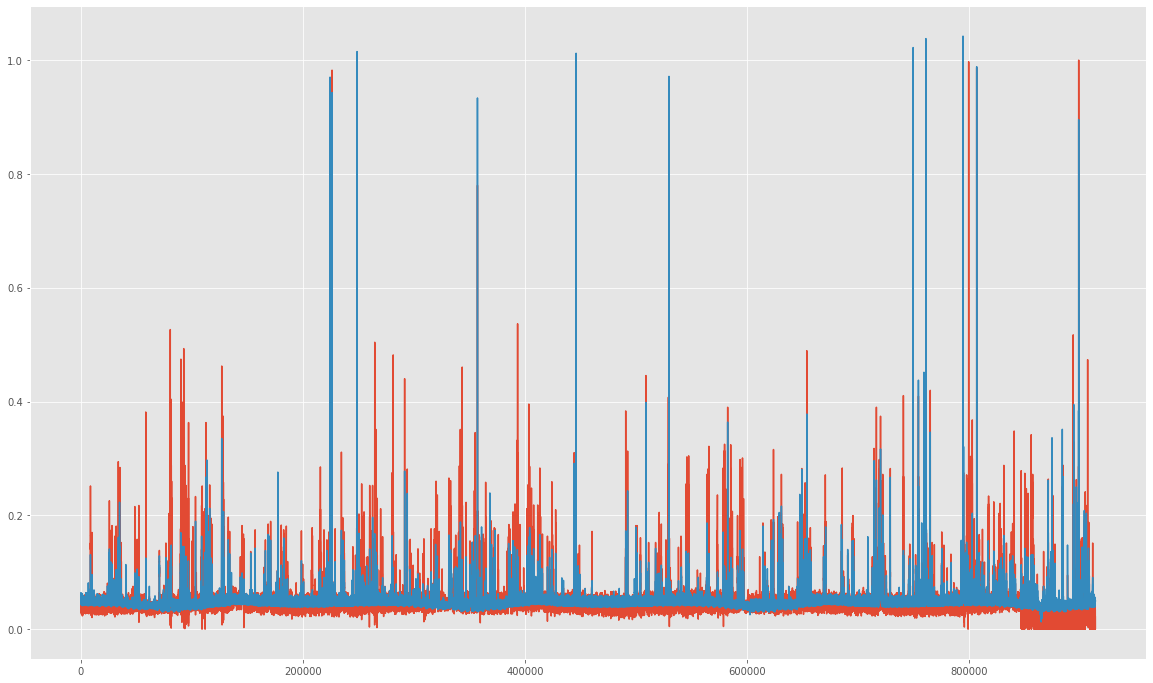

In [30]:
plt.plot(trainY)
plt.plot(trainPredict)

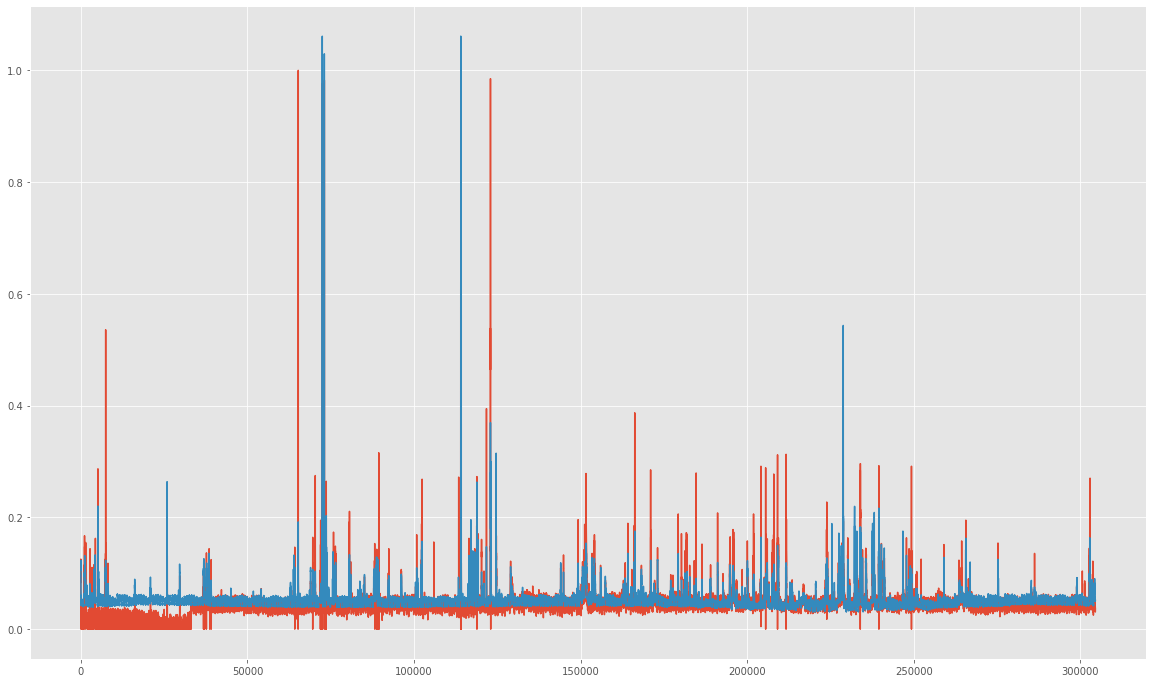

In [31]:
plt.plot(testY)
plt.plot(testPredict)

In [24]:
df_test = pd.DataFrame()
df_test['obs'] = testY
df_test['pred'] = testPredict